In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#HELPER CODE

#Validation Method
def performValidation(model, data, realScores, aucName):
    #MVDD Accuracy
    print("\n*****MVDD Validation*****")
    y_pred = model.predictScoreSet(data)
    print("y_pred", y_pred)
    y_test = realScores
    
    FP = confusion_matrix(y_test,y_pred).sum(axis=0) - np.diag(confusion_matrix(y_test,y_pred))
    FN = confusion_matrix(y_test,y_pred).sum(axis=1) - np.diag(confusion_matrix(y_test,y_pred))
    TP = np.diag(confusion_matrix(y_test,y_pred))
    TN = confusion_matrix(y_test,y_pred).sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    TPR = TPR[~np.isnan(TPR)]
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    TNR = TNR[~np.isnan(TNR)]
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    PPV = PPV[~np.isnan(PPV)]
    # Negative predictive value
    NPV = TN/(TN+FN)
    NPV = NPV[~np.isnan(NPV)]
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    FPR = FPR[~np.isnan(FPR)]
    # False negative rate
    FNR = FN/(TP+FN)
    FNR = FNR[~np.isnan(FNR)]
    # False discovery rate
    FDR = FP/(TP+FP)
    FDR = FDR[~np.isnan(FDR)]

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    aucVal = np.array(list(roc_auc.values()))
    aucVal = aucVal[~np.isnan(aucVal)]
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot and save averaged AUC graph
    plt.figure(figsize=(10, 8))
    plt.rcParams.update({'font.size': 18})
    plt.plot(fpr["micro"], tpr["micro"],
         label='Averaged AUC: {0:0.3f}'
               ''.format(roc_auc["micro"]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.legend(loc="lower right")
    plt.savefig("Graphs/"+ aucName + "Single_Averaged_AUC.png")


    #Plot class by class ROC
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)
    
    
    print("Sensitivity (TPR): %0.3f(±%0.3f)" % (np.mean(TPR), np.std(TPR) * 2))
    print("Specificity (TNR): %0.3f(±%0.3f)" % (np.mean(TNR), np.std(TNR) * 2))
    print("Precision (PPV): %0.3f(±%0.3f)" % (np.mean(PPV), np.std(PPV) * 2))
    print("Negative Predictive Value (NPV): %0.3f(±%0.3f)" % (np.mean(NPV), np.std(NPV) * 2))
    print("FPR: %0.3f(±%0.3f)" % (np.mean(FPR), np.std(FPR) * 2))
    print("FNR: %0.3f(±%0.3f)" % (np.mean(FNR), np.std(FNR) * 2))
    print("Accuracy: %0.3f(±%0.3f)" % (np.mean(ACC), np.std(ACC) * 2))
    print("Averaged AUC: %0.3f(±%0.3f)" % (np.mean(aucVal), np.std(aucVal) * 2))
    print("Micro AUC: %0.3f" % (roc_auc["micro"]))
    
    return tpr, fpr, roc_auc


# Hemodynamic Model Validation

## Label = Death
Note: validation sets only have death labels to validate for hemo

### Cardiogenic Shock

In [3]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')


*****MVDD Validation*****
y_pred [5 3 3 4 4 5 1 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 3 5 5 5 5 5 5 3 5 5 3 5
 5 5 5 5 5 5 5 5 5 4 4 3 5 5 5 5 5 5 3 3 3 3 3 1 1 1 1 4 4 4 4 5 5 5 5 5 4
 4 4 3 4 5 5 3 3 4 4 1 4 5 5 5 4 4 3 5 4 5 5 5 5 5 3 3 5 5 5 3 3 3 3 3 3 3
 5 3 5 5 3 4 5 5 5 5 5 5 5 5 5 5 5 4 3 5 5 5 5 5 5 5 5 5 3 3 3 5 5 3 3 3 5
 5 3 3 3 5 5 5 3 3 3 5 3 5 5 4 5 4 4 5 3 3 5 3 5 5 5 3 5 5 3 3 4 4 4 4 4 4
 4 4 5 3 5 5 5 5 5 5 5 4 4 4 4 4 4 3 3 5 3 5 4 5 5 5 4 4 4 4 4 4 3 4 4 4 4
 5 5 3 5 5 3 5 4 4 4 3 3 5 4 4 4 4 4 4 3 3 3 3 3 4 4 4 5 4 4 4 4 1 4 1 1 1
 1 1 4 3 5 5 5 5 5 5 5 3 5 5 5 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 3 3 3 3 5 4]


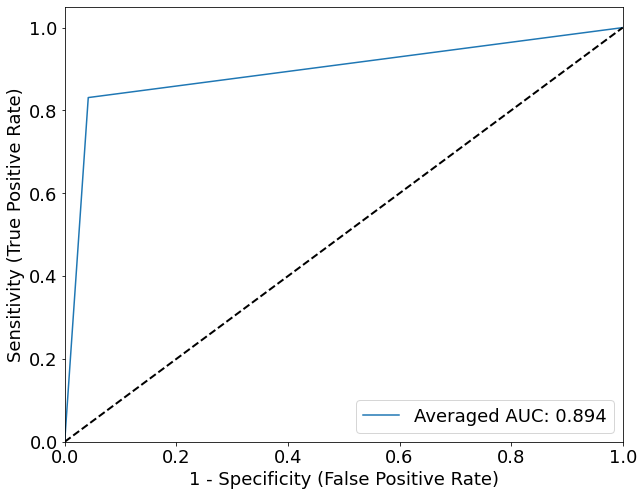

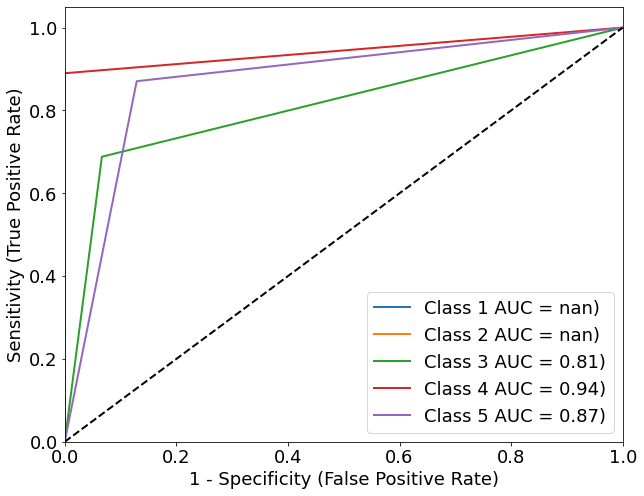

Sensitivity (TPR): 0.816(±0.182)
Specificity (TNR): 0.941(±0.094)
Precision (PPV): 0.647(±0.766)
Negative Predictive Value (NPV): 0.939(±0.078)
FPR: 0.059(±0.094)
FNR: 0.184(±0.182)
Accuracy: 0.916(±0.089)
Averaged AUC: 0.876(±0.110)
Micro AUC: 0.894


In [4]:
hemoCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
cardShocktpr, cardShockfpr, cardShockroc_auc = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoCardShockDeLvTx')


### Serial Cardiac

In [5]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')


*****MVDD Validation*****
y_pred [4 4 4 4 1 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 3 4 3 3 3 5 3 5 4 3 3
 4 4 4 5 5 3 3 4 4 4 4 4 4 4 4 4 4 1 5 5 4 4 4 5 5 3 5 5 5 3 3 3 5 5 3 4 4
 4 4 4 4 4 4 4 3 3 5 3 5 5 3 5 3 3 5 5 4 4 5 5 5 5 5 5 5 5 3 4 4 4 4 5 5 5
 5 5 5 5 5 3 3 3 3 3 3 3 4 4 4 4 3 5 5 5 5 5 3 3 4 4 4 5 3 5 5 5 5 4 4 4 4
 4 4 4 1 3 3 3 3 3 3 2 1 1 1 1 4 4 4 4 4 4 4 4 5 5 5 5 1 1 5 5 5 5 4 4 3 2
 4 4 4 4 5 5 3 5 5 5 5 3 5 4 4 4 4 4 5 5 4 4 3 3 3 3 3 3 1 1 1 1 1 3 5 5 5
 5 2 4 4 4 5 5 4 4 4 4 4 4 3 3 3 3 3 5 5 3 3 5 5 5 5 5 5 2 4 4 4 4 4 4 4 3
 5 5 5 3 3 3 3 4 4 4 4 4 4 5 5 3 3 3 3 3 3 3 3 3 1 5 5 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 3 3 2 5 3 5 5 1 1 4 3 3 3 3 3 3 3
 3 3 3 5 5 3 3 3 5 5 3 3 3 4 4 4 5 3 3 3 5 3 5 5 1 3 3 3 5 5 3 3 5 5 3 3 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 3 4 4 3 3 3 4 4 4 4 4 4 4 5 5 3 3
 3 3 3 4 4 4 5 5 3 3 3 4 4 5 5 5 5 5 5 5 4 4 4 4 3 5 5 3 3 1 1 1 1 1 1 1 1
 1 1 4 3 5 5 5 3 4 4 3 3 3 2 5 5 5 5 4 4 4 4 5 5 5 4 4 4 4 4 4 4 4

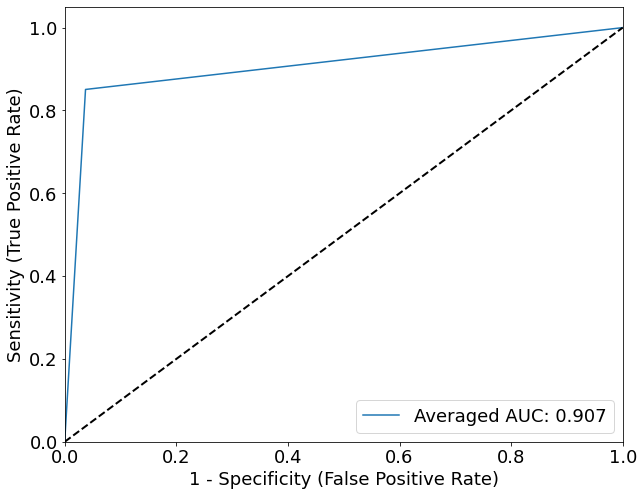

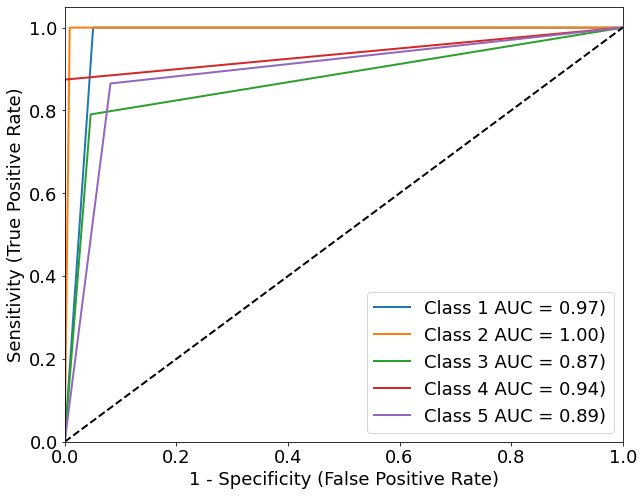

Sensitivity (TPR): 0.906(±0.164)
Specificity (TNR): 0.962(±0.060)
Precision (PPV): 0.607(±0.720)
Negative Predictive Value (NPV): 0.957(±0.071)
FPR: 0.038(±0.060)
FNR: 0.094(±0.164)
Accuracy: 0.940(±0.064)
Averaged AUC: 0.934(±0.094)
Micro AUC: 0.907


In [6]:
hemoCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
serialtpr, serialfpr, serialroc_auc = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoSerialCardiacDeLvTx')

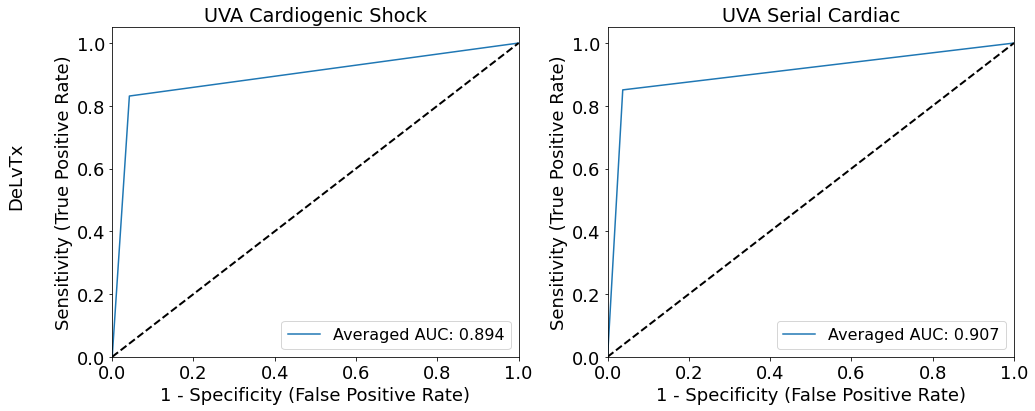

In [7]:
# Plot summary of Invasive Hemo Cardio Shock 

def plot_roc_auc(axs, col, tpr, fpr, roc_auc, title):
    axs[col].plot(fpr["micro"], tpr["micro"],
         label='Averaged AUC: {0:0.3f}'
               ''.format(roc_auc["micro"]))

    axs[col].plot([0, 1], [0, 1], 'k--', lw=2)
    axs[col].set_xlim([0.0, 1.0])
    axs[col].set_ylim([0.0, 1.05])
    axs[col].set_title(title)
    axs[col].set_xlabel('1 - Specificity (False Positive Rate)')
    axs[col].set_ylabel('Sensitivity (True Positive Rate)')
    axs[col].legend(loc="lower right")

    
fig, axs = plt.subplots(1, 2, figsize=(14,6))
plt.rcParams.update({'font.size': 16})
plot_roc_auc(axs, 0, cardShocktpr, cardShockfpr, cardShockroc_auc, title="UVA Cardiogenic Shock")
plot_roc_auc(axs, 1, serialtpr, serialfpr, serialroc_auc, title="UVA Serial Cardiac")
plt.figtext(-0.03, 0.5, "DeLvTx", fontsize=18, rotation=90)
fig.tight_layout()


# All Data Model Validation

## Label = Death

### HF-ACTION All Data Validation

In [8]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****
y_pred [4 2 3 ... 3 4 3]


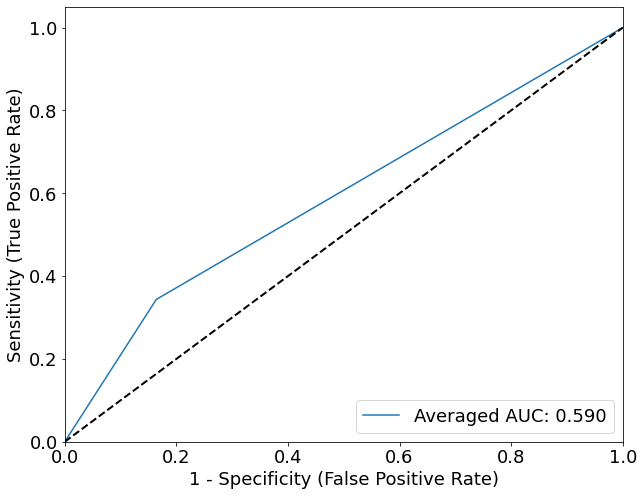

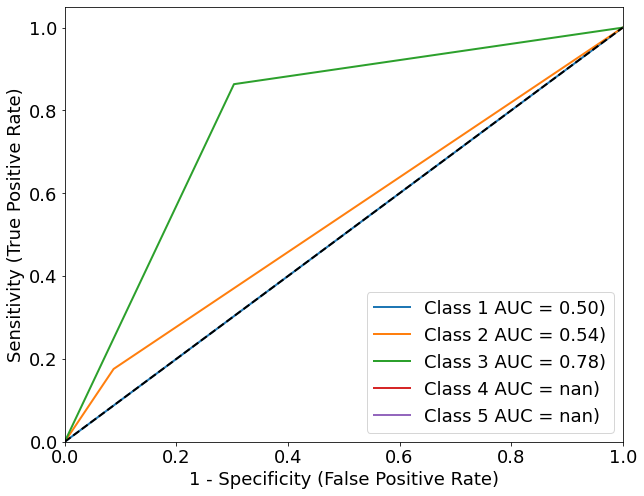

Sensitivity (TPR): 0.346(±0.745)
Specificity (TNR): 0.802(±0.321)
Precision (PPV): 0.405(±0.581)
Negative Predictive Value (NPV): 0.811(±0.362)
FPR: 0.198(±0.321)
FNR: 0.654(±0.745)
Accuracy: 0.672(±0.207)
Averaged AUC: 0.608(±0.246)
Micro AUC: 0.590


In [9]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
hfActionDeathtpr, hfActionDeathfpr, hfActionDeathroc_auc = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataHFactionDeLvTx')

### BEST All Data Validation

In [10]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****
y_pred [4 3 4 ... 4 3 4]


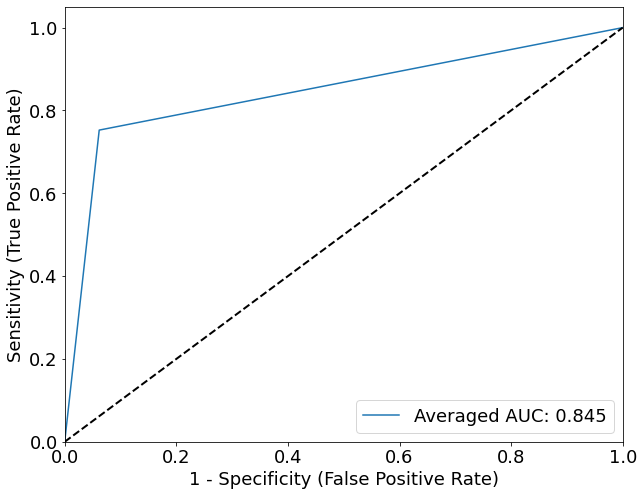

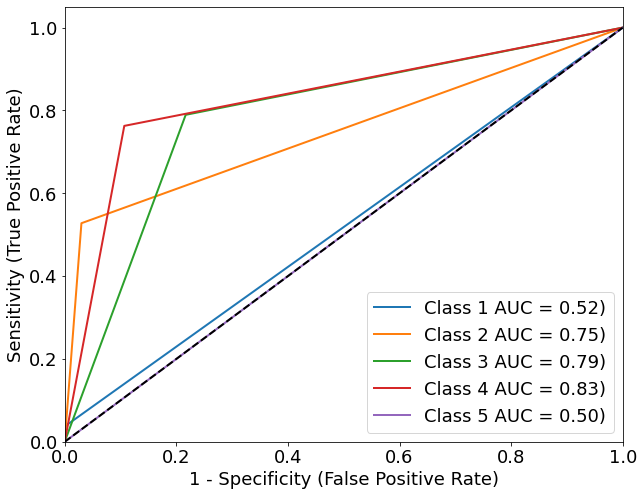

Sensitivity (TPR): 0.423(±0.686)
Specificity (TNR): 0.929(±0.166)
Precision (PPV): 0.557(±0.886)
Negative Predictive Value (NPV): 0.821(±0.696)
FPR: 0.071(±0.166)
FNR: 0.577(±0.686)
Accuracy: 0.901(±0.207)
Averaged AUC: 0.676(±0.278)
Micro AUC: 0.845


In [11]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
bestDeathtpr, bestDeathfpr, bestDeathroc_auc = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataBestDeLvTx')

### GUIDE-IT All Data Validation

In [12]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****
y_pred [3 3 3 ... 4 4 4]


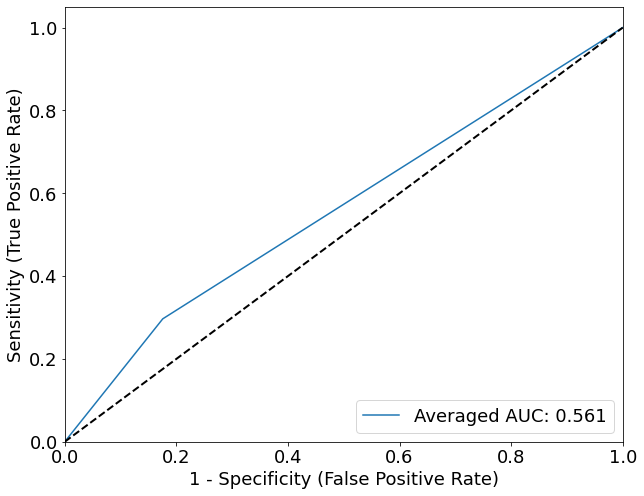

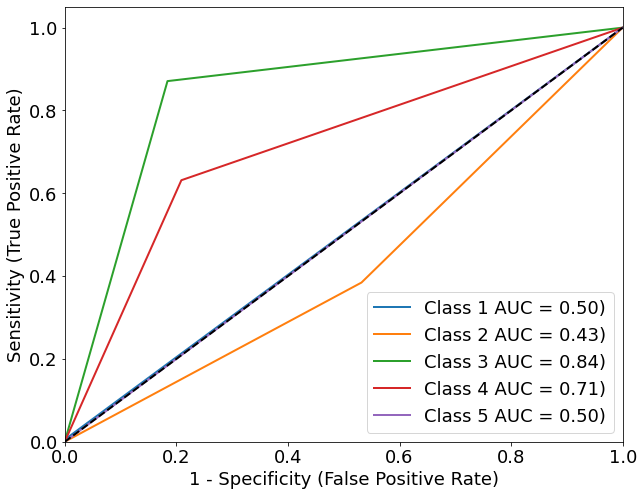

Sensitivity (TPR): 0.379(±0.686)
Specificity (TNR): 0.815(±0.388)
Precision (PPV): 0.395(±0.508)
Negative Predictive Value (NPV): 0.817(±0.416)
FPR: 0.185(±0.388)
FNR: 0.621(±0.686)
Accuracy: 0.719(±0.403)
Averaged AUC: 0.597(±0.311)
Micro AUC: 0.561


In [13]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
guideDeathtpr, guideDeathfpr, guideDeathroc_auc = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataGuideItDeLvTx')

## Label = Rehospitalization
Note: Only HF-ACTION, BEST and GUIDE-IT have rehosp

### HF-ACTION All Data Validation

In [14]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****
y_pred [1 1 4 ... 4 1 4]


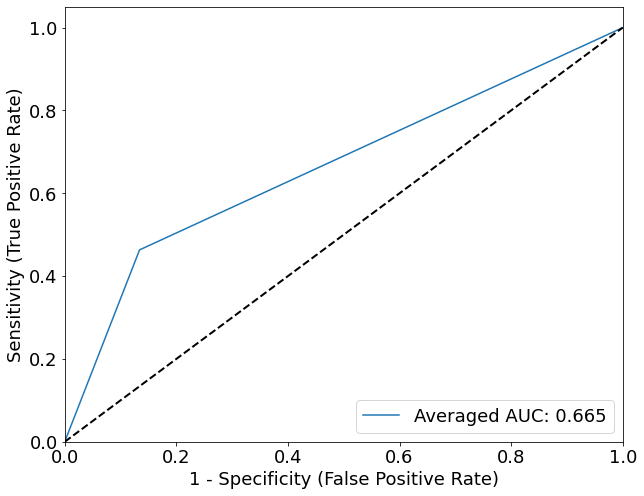

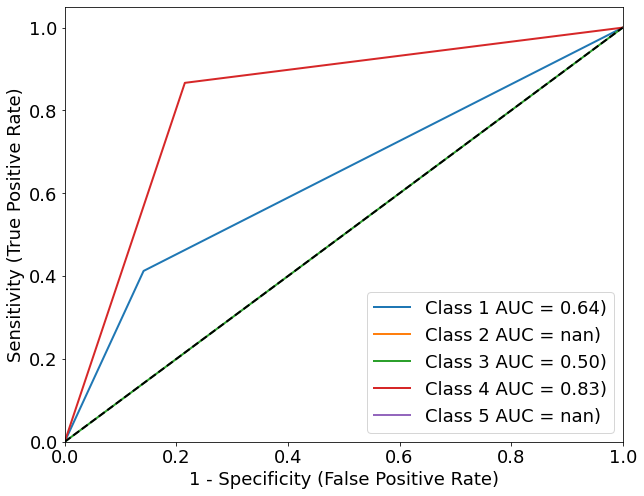

Sensitivity (TPR): 0.426(±0.708)
Specificity (TNR): 0.832(±0.229)
Precision (PPV): 0.458(±0.655)
Negative Predictive Value (NPV): 0.831(±0.312)
FPR: 0.168(±0.229)
FNR: 0.574(±0.708)
Accuracy: 0.732(±0.148)
Averaged AUC: 0.654(±0.267)
Micro AUC: 0.665


In [15]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
hfActionRehosptpr, hfActionRehospfpr, hfActionRehosproc_auc = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFactionRehosp')

### BEST All Data Validation

In [16]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****
y_pred [5 5 5 ... 5 5 5]


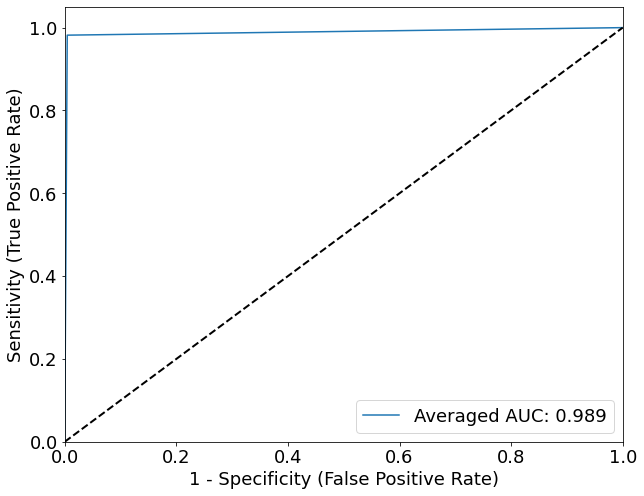

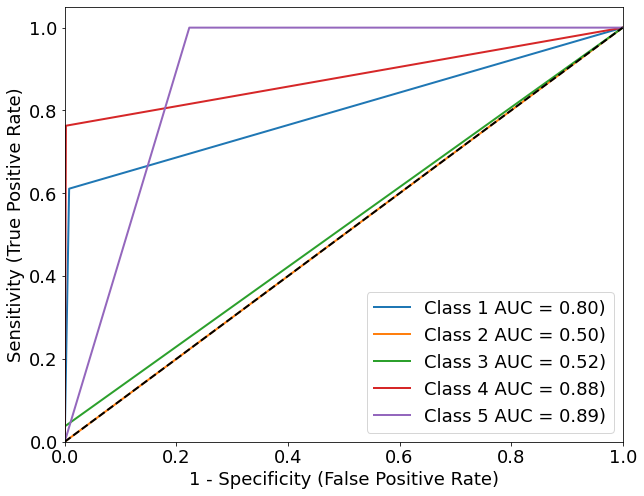

Sensitivity (TPR): 0.482(±0.797)
Specificity (TNR): 0.953(±0.177)
Precision (PPV): 0.830(±0.405)
Negative Predictive Value (NPV): 0.996(±0.007)
FPR: 0.047(±0.177)
FNR: 0.518(±0.797)
Accuracy: 0.993(±0.008)
Averaged AUC: 0.718(±0.346)
Micro AUC: 0.989


In [17]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
bestRehosptpr, bestRehospfpr, bestRehosproc_auc = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataBestRehosp')

### GUIDE-IT All Data Validation

In [18]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****
y_pred [5 4 4 ... 5 5 5]


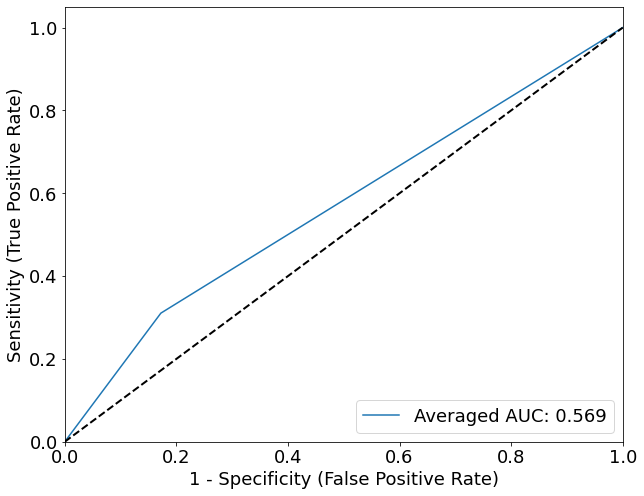

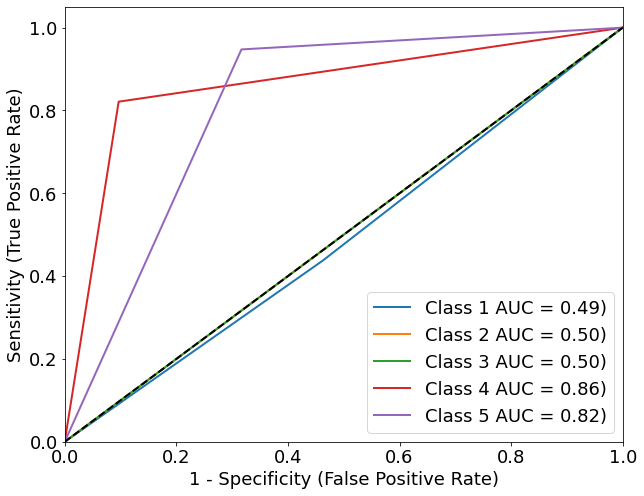

Sensitivity (TPR): 0.441(±0.795)
Specificity (TNR): 0.825(±0.369)
Precision (PPV): 0.343(±0.464)
Negative Predictive Value (NPV): 0.827(±0.394)
FPR: 0.175(±0.369)
FNR: 0.559(±0.795)
Accuracy: 0.724(±0.385)
Averaged AUC: 0.633(±0.337)
Micro AUC: 0.569


In [19]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
guideRehosptpr, guideRehospfpr, guideRehosproc_auc = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataGuideItRehosp')

## Label = Readmission
Note: only HF-ACTION has readm

### HF-ACTION All Data Validation

In [20]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Readmission')


*****MVDD Validation*****
y_pred [3 4 4 ... 4 4 4]


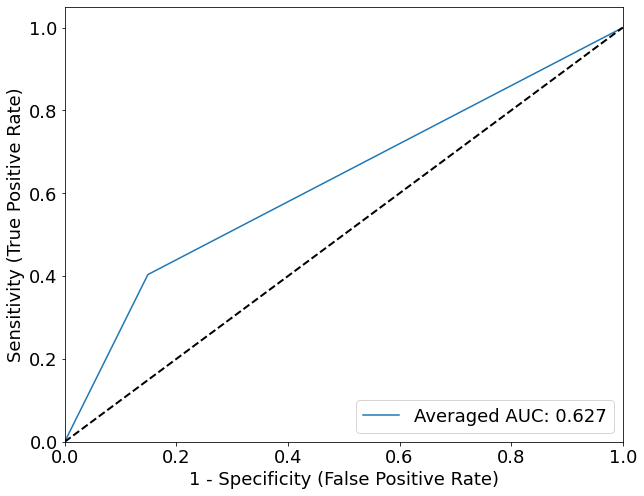

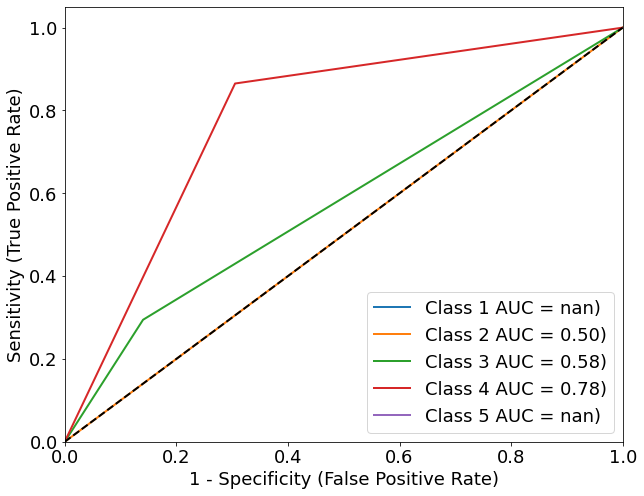

Sensitivity (TPR): 0.387(±0.718)
Specificity (TNR): 0.811(±0.258)
Precision (PPV): 0.407(±0.587)
Negative Predictive Value (NPV): 0.817(±0.344)
FPR: 0.189(±0.258)
FNR: 0.613(±0.718)
Accuracy: 0.702(±0.164)
Averaged AUC: 0.619(±0.236)
Micro AUC: 0.627


In [21]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreReadmission']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
hfActionReadmtpr, hfActionReadmfpr, hfActionReadmroc_auc = performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFactionReadm')

## Plot All Data ROC Curves

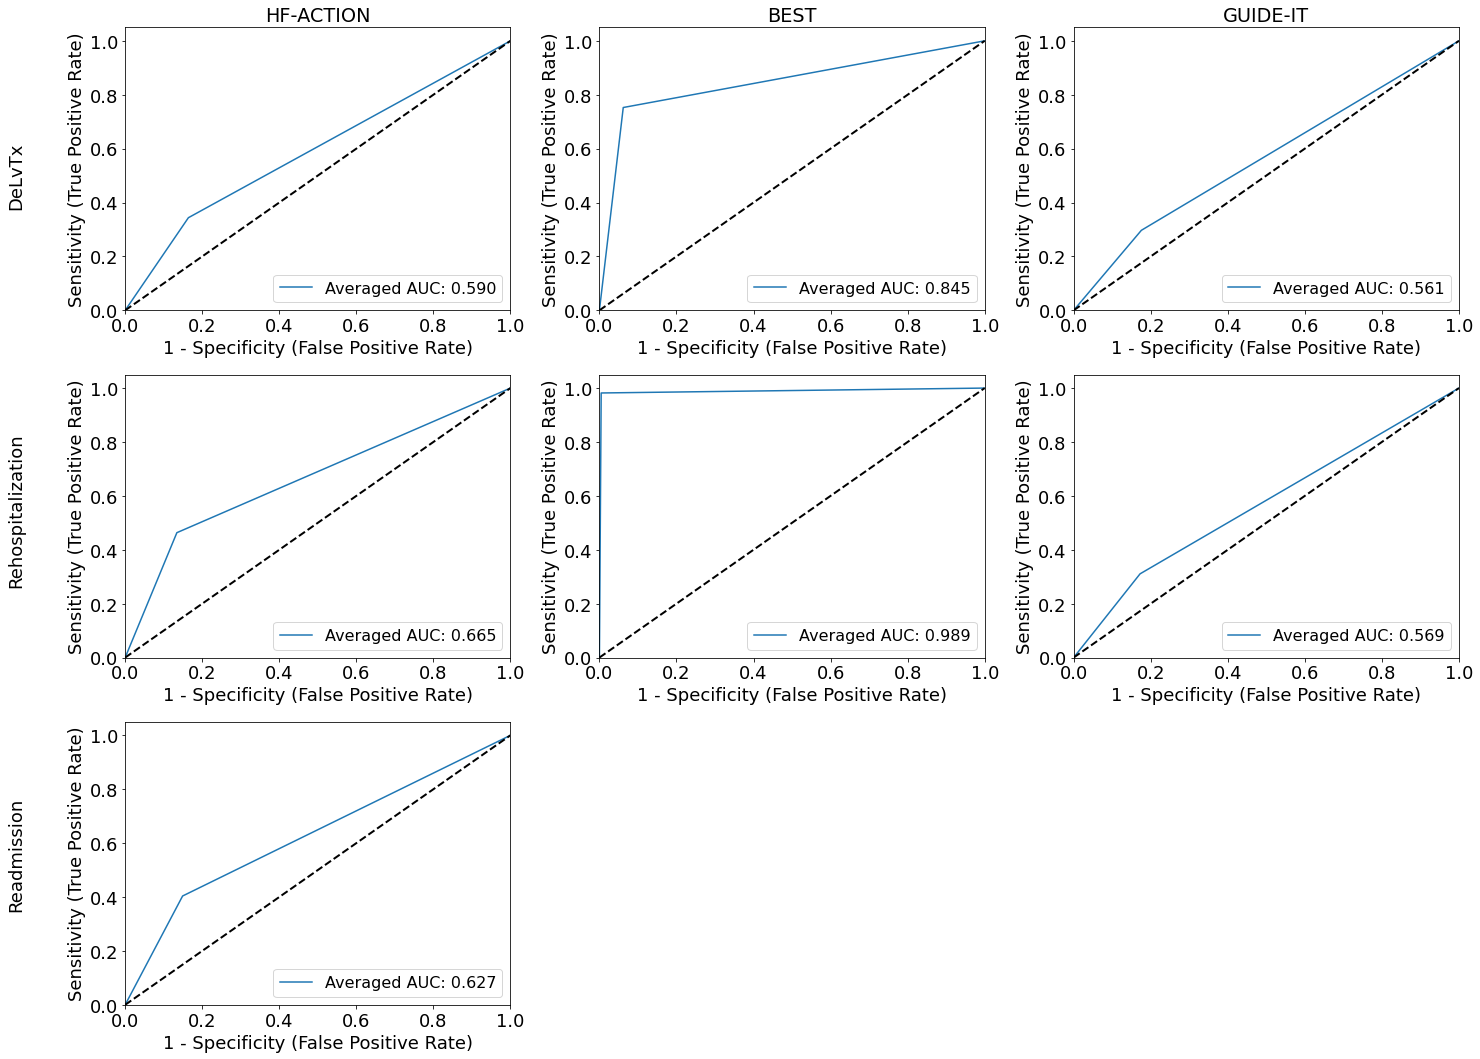

In [22]:
def plot_roc_auc(axs, row, col, tpr, fpr, roc_auc, title):
    axs[row,col].plot(fpr["micro"], tpr["micro"],
         label='Averaged AUC: {0:0.3f}'
               ''.format(roc_auc["micro"]))

    axs[row,col].plot([0, 1], [0, 1], 'k--', lw=2)
    axs[row,col].set_xlim([0.0, 1.0])
    axs[row,col].set_ylim([0.0, 1.05])
    axs[row,col].set_title(title)
    axs[row,col].set_xlabel('1 - Specificity (False Positive Rate)')
    axs[row,col].set_ylabel('Sensitivity (True Positive Rate)')
    axs[row,col].legend(loc="lower right")



fig, axs = plt.subplots(3, 3, figsize=(20,15))
plt.rcParams.update({'font.size': 16})
plot_roc_auc(axs, 0, 0, hfActionDeathtpr, hfActionDeathfpr, hfActionDeathroc_auc, title="HF-ACTION")
plot_roc_auc(axs, 0, 1, bestDeathtpr, bestDeathfpr, bestDeathroc_auc, title="BEST")
plot_roc_auc(axs, 0, 2, guideDeathtpr, guideDeathfpr, guideDeathroc_auc, title="GUIDE-IT")

plot_roc_auc(axs, 1, 0, hfActionRehosptpr, hfActionRehospfpr, hfActionRehosproc_auc, title="")
plot_roc_auc(axs, 1, 1, bestRehosptpr, bestRehospfpr, bestRehosproc_auc, title="")
plot_roc_auc(axs, 1, 2, guideRehosptpr, guideRehospfpr, guideRehosproc_auc, title="")

plot_roc_auc(axs, 2, 0, hfActionReadmtpr, hfActionReadmfpr, hfActionReadmroc_auc, title="")

fig.delaxes(axs[2][1])
fig.delaxes(axs[2][2])

plt.figtext(-0.03, 0.8, "DeLvTx", fontsize=18, rotation=90)
plt.figtext(-0.03, 0.45, "Rehospitalization", fontsize=18, rotation=90)
plt.figtext(-0.03, 0.15, "Readmission", fontsize=18, rotation=90)

fig.tight_layout()
